In [244]:
import requests
import json
import matplotlib.pyplot as plt
import pickle
from collections import Counter
import os
import pprint
import pandas as pd

First, let's set the league_id, current GW, and user IDs

In [245]:
league_id = '780695' ##CHANGE ME to your league's ID 
GW=str(3) ##CHANGE ME to the gameweek you want to analyze

In [246]:
# lets get the user IDs for the league
with open(rf"league_{league_id}/league_data/league_{league_id}_entry_to_player_dict.pickle", "rb") as entry_to_player_mapping:
    entry_to_player_mapping = pickle.load(entry_to_player_mapping)

user_ids = list(entry_to_player_mapping.keys())

# Gameweek specific info
- chip usage
- captaincy
- most owned players
- differentials
- transfers in/out

Let's get some data from the FPL API for all players:
- ID->Name mapping 
- ID->Price mapping 
- ID->Points mapping 

In [247]:
# Send a GET request to the FPL website
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
data = response.json()

all_players = data['elements']

player_to_id_mapping = {}
player_to_price_mapping = {}
player_to_points_mapping = {}

for i, player in enumerate(all_players):
    player_id = player['id']
    player_name = player['web_name']
    player_price = player['now_cost']
    player_points = player['total_points']

    player_to_price_mapping[player_id] = player_price
    player_to_id_mapping[player_id] = player_name
    player_to_points_mapping[player_id] = player_points

# save dicts with pickle, just in case
with open(f"fpl_player_data/player_to_id_mapping.pickle", 'wb') as file:
    pickle.dump(player_to_id_mapping, file)
with open(f"fpl_player_data/player_to_price_mapping.pickle", 'wb') as file:
    pickle.dump(player_to_price_mapping, file)
with open(f"fpl_player_data/player_to_points_mapping.pickle", 'wb') as file:
    pickle.dump(player_to_points_mapping, file)

Let's also get all the team data for the league and current GW

In [248]:
def get_gw_teams(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}'):
    # to store all owned players
    players_data = []

    # fetch the team data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            picks = data['picks']

            for pick in picks:
                # get player ID
                player_id = pick['element']
                # get player info
                player_name = player_to_id_mapping[player_id]
                player_price = player_to_price_mapping[player_id]
                player_points = player_to_points_mapping[player_id]
                captain = pick['is_captain'] # True or False

                # add player info list
                players_data.append({
                    'player_name': player_name,
                    'player_price': player_price,
                    'player_points': player_points,
                    'is_captain': captain
                })

    # convert data to pandas df
    df = pd.DataFrame(players_data)

    # group df by player name, and aggregate info
    df_summary = df.groupby('player_name').agg(
        own_count=('player_name', 'size'),
        captaincy_count=('is_captain', 'sum'),
        price=('player_price', 'first'),
        points=('player_points', 'first')
    ).reset_index()

    # save
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        df_summary.to_csv(f'{save_dir}/team_summary_GW{GW}.csv', index=False)
    return df_summary
    

In [249]:
df = get_gw_teams(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}')
df.head()

,player_name,own_count,captaincy_count,price,points
0,A.Becker,3,0,55,21
1,Adingra,1,0,55,11
2,Aina,1,0,44,12
3,Alexander-Arnold,6,0,70,20
4,Amad,2,0,50,10


# Current GW active chips

In [250]:
def plot_active_chips(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}'):

    # to store active chips
    active_chips = []

    # fetch the chip data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            chip = data['active_chip']
            if chip:
                active_chips.append(chip)

    # plot active chips
    plt.figure(figsize=(4, 2))
    plt.bar(active_chips, [active_chips.count(chip) for chip in active_chips])
    plt.xlabel(f'Chips')
    plt.ylabel('Count')
    plt.title(f'Active Chips for GW{GW}')
    plt.tight_layout()
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/active_chips_GW{GW}.png')
    plt.show()


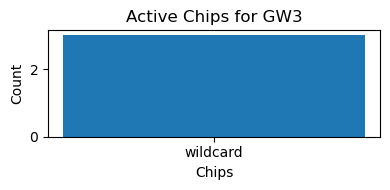

In [251]:
plot_active_chips(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}')

# Captaincy for current GW

In [252]:
def plot_captaincy(team_df, GW, save_dir=f'league_{league_id}/output/GW{GW}'):
    """
    Plots the captaincy distribution for a given game week (GW) and optionally saves the plot to a specified directory.

    Parameters:
    - team_df (DataFrame): The DataFrame containing player data, including captaincy counts.
    - GW (int): The game week for which the captaincy distribution is being plotted.
    - save_dir (str, optional): The directory path where the plot image will be saved. The default is a path formatted as 'league_<league_id>/output/GW<GW>'.
    """
    # sort df by captaincy count
    sorted_df = team_df.sort_values(by='captaincy_count', ascending=False)
    sorted_df = sorted_df[sorted_df['captaincy_count'] > 0]

    # plot captaincy
    plt.figure(figsize=(8, 6))
    bars = plt.bar(sorted_df['player_name'], sorted_df['captaincy_count'], color='royalblue')
    plt.xlabel('Captains')
    plt.ylabel('Count')
    plt.title(f'Captains for GW{GW}')
    plt.xticks(rotation=30)

    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate
            yval + 0.1,  # Y coordinate with added space above the bar
            int(yval),  # Text to display
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )
        
    plt.tight_layout()
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/captaincy_GW{GW}.png')
    plt.show()

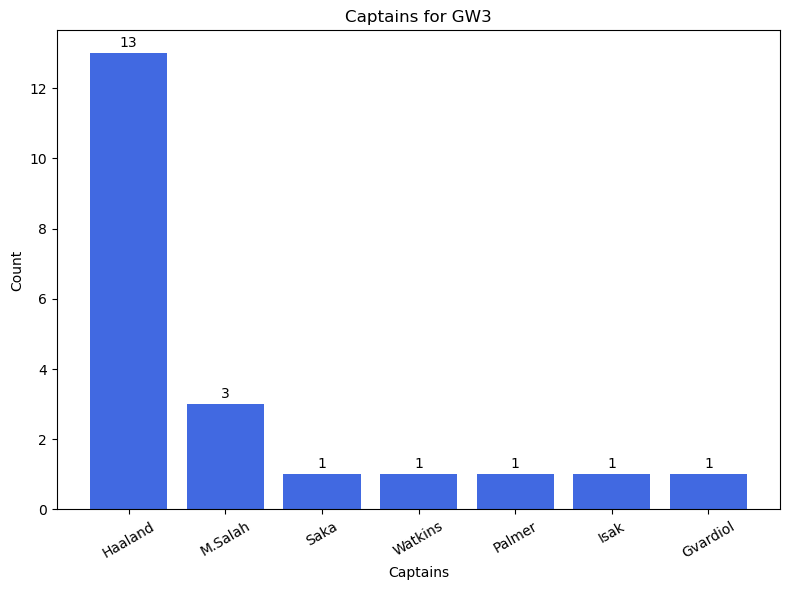

In [253]:
plot_captaincy(df, GW, save_dir=f'league_{league_id}/output/GW{GW}')

# Get most owned players

In [254]:
def plot_most_owned(team_df, GW, N_most_owned=20, save_dir=f'league_{league_id}/output/GW{GW}'):
    """
    Plots the top N most owned players based on the own_count column.
    
    Parameters:
    team_df (DataFrame): The DataFrame containing player data.
    GW (int): the current GW
    N_most_owned (int): The number of top players to display. Default is 10.
    save_dir: Where to save the plot. Default is 'league_{league_id}/output/GW{GW}'.
    """
    # Sort the DataFrame by own_count in descending order and select the top N players
    top_owned_df = team_df.sort_values(by='own_count', ascending=False).head(N_most_owned)
    
    # plot ownership
    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_owned_df['player_name'], top_owned_df['own_count'], color='skyblue', edgecolor='grey')

    plt.xlabel('Player')
    plt.ylabel('Own Count')
    plt.title(f'Top {N_most_owned} Most Owned Players for GW{GW}')
    plt.xticks(rotation=45)
    
    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate
            yval + 0.1,  # Y coordinate with added space above the bar
            int(yval),  # Text to display
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )
    
    plt.tight_layout()
    # save
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/most_owned_GW{GW}.png')
    plt.show()


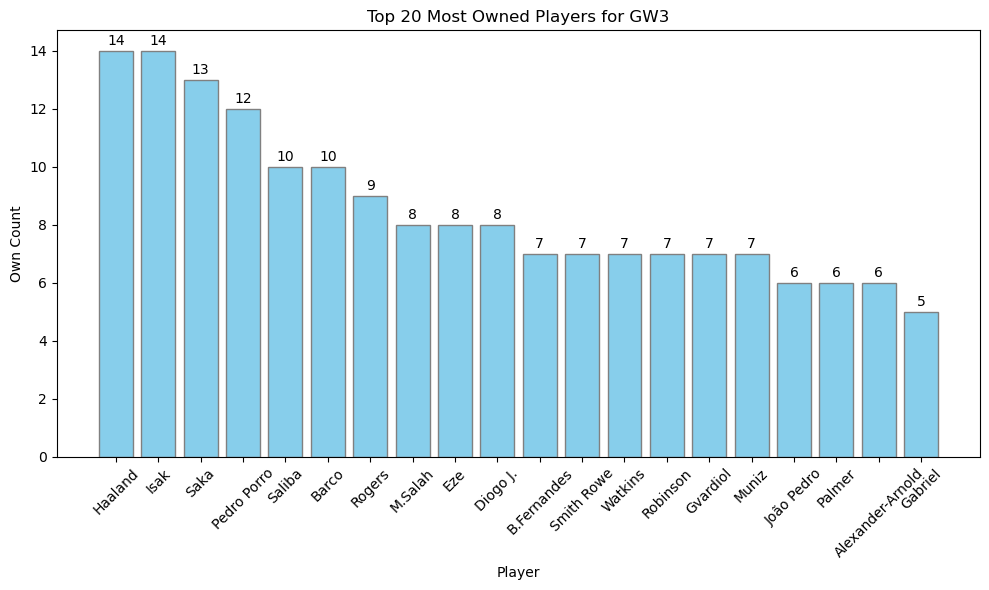

In [255]:
plot_most_owned(df, GW, N_most_owned=20, save_dir=f'league_{league_id}/output/GW{GW}')

## Differentials

Low owned, high price 

In [305]:
def plot_differentials_by_price(team_df, GW, own_max, topN=10, save_dir=f'league_{league_id}/output/GW{GW}'):
    """
    Plots the differentials based on player price.
    
    Parameters:
    team_df (DataFrame): The DataFrame containing player data.
    GW (int): the current GW
    own_min (int): The minimum number of owners for a player to be considered a differential.
    topN (int): The number of top differentials to display.
    save_dir: Where to save the plot. Default is 'league_{league_id}/output/GW{GW}'.
    """
    # filter players with own_count greater than or equal to own_min - how to define what is a "differential"
    diff_df = team_df[team_df['own_count'] <= own_max]

    # sort by player price
    diff_df = diff_df.sort_values(by='price', ascending=False).head(topN)


    
    # calculate differential
    diff_df['differential'] = diff_df['own_count'].apply(lambda x: len(user_ids) - x)

    # plot differentials
    plt.figure(figsize=(10, 6))
    bars = plt.bar(diff_df['player_name'], diff_df['price'], color='pink', edgecolor='grey')

    plt.xlabel('Player')
    plt.ylabel('Price')
    plt.title(f'Top {topN} differentials, based on price')
    plt.xticks(rotation=30)
    
    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate
            yval + 0.2,  # Y coordinate with added space above the bar
            str(float(str(yval)[:-1] + '.' + str(yval)[-1])), # Text to display - add decimal points bc it's price
            # int(yval),  # Text to display
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )
    
    plt.tight_layout()

    # save
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/differentials_by_price_GW{GW}.png')
    plt.show()
    

Differential is defined as being owned by less than 5 users


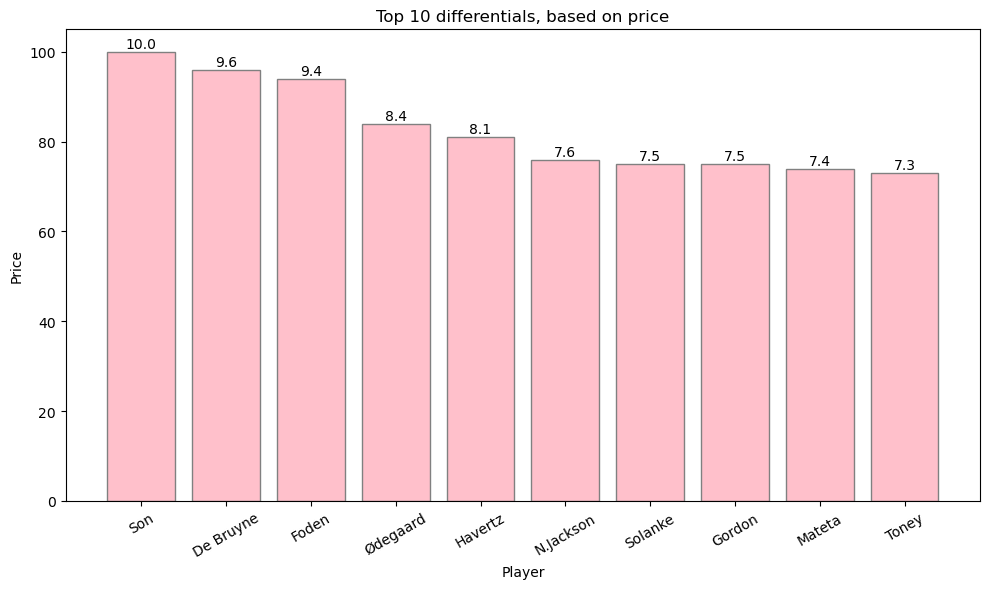

In [306]:
# define differential via percent max owned
min_percent_owned = .25
own_max = int(len(user_ids)*min_percent_owned)
print(f"Differential is defined as being owned by less than {own_max} users")

plot_differentials_by_price(team_df=df, GW=GW, own_max=own_max, topN=10, save_dir=f'league_{league_id}/output/GW{GW}')

Low owned, high points

In [258]:
def plot_differentials_by_points(team_df, GW, own_max, topN=10, save_dir=f'league_{league_id}/output/GW{GW}'):
    """
    Plots the differentials based on player points.
    
    Parameters:
    team_df (DataFrame): The DataFrame containing player data.
    GW (int): the current GW
    own_min (int): The minimum number of owners for a player to be considered a differential.
    topN (int): The number of top differentials to display.
    save_dir: Where to save the plot. Default is 'league_{league_id}/output/GW{GW}'.
    """
    # filter players with own_count greater than or equal to own_min - how to define what is a "differential"
    diff_df = team_df[team_df['own_count'] <= own_max]

    # sort by player price
    diff_df = diff_df.sort_values(by='points', ascending=False).head(topN)


    
    # calculate differential
    diff_df['differential'] = diff_df['own_count'].apply(lambda x: len(user_ids) - x)

    # plot differentials
    plt.figure(figsize=(10, 6))
    bars = plt.bar(diff_df['player_name'], diff_df['points'], color='rebeccapurple', edgecolor='grey')

    plt.xlabel('Player')
    plt.ylabel('Points')
    plt.title(f'Top {topN} differentials, based on points')
    plt.xticks(rotation=30)
    
    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate
            yval + 0.2,  # Y coordinate with added space above the bar
            int(yval),  # Text to display
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )
    
    plt.tight_layout()

    # save
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/differentials_by_points_GW{GW}.png')
    plt.show()
    

Differential is defined as being owned by less than 5 users


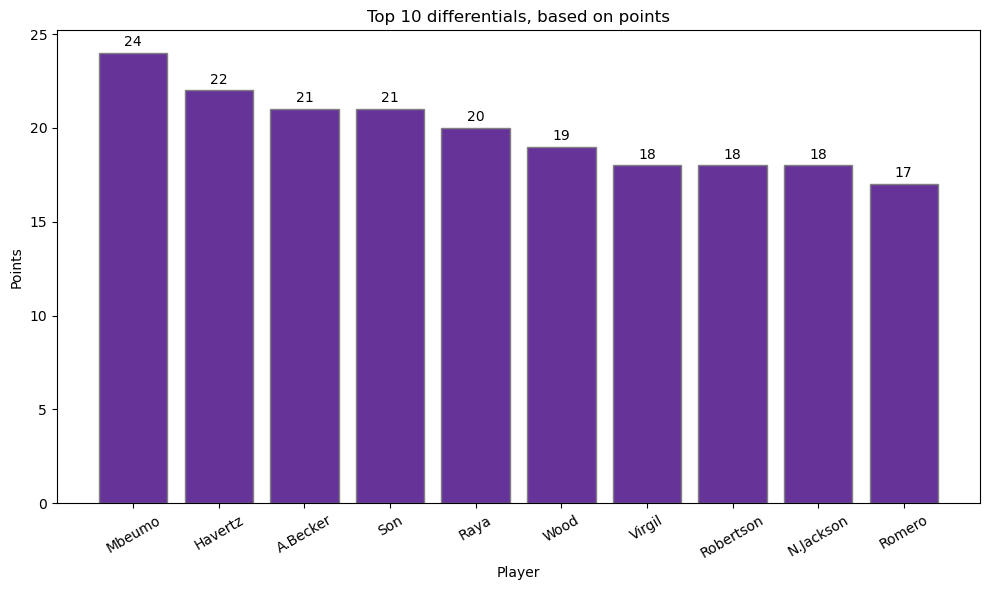

In [259]:
# define differential via percent max owned
min_percent_owned = .25
own_max = int(len(user_ids)*min_percent_owned)
print(f"Differential is defined as being owned by less than {own_max} users")

plot_differentials_by_points(df, GW=GW, own_max=own_max, topN=10, save_dir=f'league_{league_id}/output/GW{GW}')

## All transfers in/out

In [289]:
def get_transfers_df(user_ids, GW=GW, save_dir=None):

    # to concat all users
    transfers_df = pd.DataFrame(columns=['element_in', 'element_in_cost', 'element_out', 'element_out_cost',
       'entry', 'event', 'time'])
    
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/transfers/"
        response = requests.get(url)
        if response.status_code == 200:
            # concat transfers for this user to df
            transfers_df = pd.concat([transfers_df, pd.DataFrame(response.json())])

    # filter for current GW
    transfers_df_gw = transfers_df[transfers_df['event'] == int(GW)]

    # df for transfers in and out
    df_in = transfers_df_gw[['element_in']].copy()
    df_in['player_name'] = df_in['element_in'].map(player_to_id_mapping)

    df_out = transfers_df_gw[['element_out']].copy()
    df_out['player_name'] = df_out['element_out'].map(player_to_id_mapping)

    # group by player name and get counts
    df_in = df_in.groupby('player_name').agg(
        transfers_in=('player_name', 'size')
    ).reset_index().sort_values(by='transfers_in', ascending=False)

    df_out = df_out.groupby('player_name').agg(
        transfers_out=('player_name', 'size')
    ).reset_index().sort_values(by='transfers_out', ascending=False)

    # save
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        df_in.to_csv(f'{save_dir}/transfers_in_GW{GW}.csv', index=False)
        df_out.to_csv(f'{save_dir}/transfers_out_GW{GW}.csv', index=False)

    return df_in, df_out

In [291]:
df_in, df_out = get_transfers_df(user_ids, GW=GW, save_dir=f'league_{league_id}/output/GW{GW}')

In [301]:
df_in.head()

,player_name,transfers_in
30,Rogers,6
15,Lewis,3
14,João Pedro,3
26,Nedeljkovic,3
18,M.Salah,2


In [302]:
df_out.head()

,player_name,transfers_out
26,Nkunku,7
16,Isak,3
0,B.Fernandes,2
13,Havertz,2
1,Barco,2


In [311]:
def plot_transfers_in_out(df_in, df_out, save_dir=f'league_{league_id}/output/GW{GW}'):
    """
    Plots the transfers in and out for a given game week (GW).

    Parameters:
    - df_in (DataFrame): The DataFrame containing the transfers in data.
    - df_out (DataFrame): The DataFrame containing the transfers out data.
    """
    ############################
    ##### plot transfers in ####
    ############################
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_in['player_name'], df_in['transfers_in'], color='seagreen', edgecolor='grey')

    plt.xlabel('Player')
    plt.ylabel('Transfers In')
    plt.title(f'Transfers In for GW{GW}')
    plt.xticks(rotation=55)
    
    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate
            yval + 0.05,  # Y coordinate with added space above the bar
            int(yval),  # Text to display
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )
    
    plt.tight_layout()

    # save 
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/transfers_in_GW{GW}.png')
    plt.show()

    ############################
    #### plot transfers out ####
    ############################
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_out['player_name'], df_out['transfers_out'], color='crimson', edgecolor='grey')

    plt.xlabel('Player')
    plt.ylabel('Transfers Out')
    plt.title(f'Transfers Out for GW{GW}')
    plt.xticks(rotation=55)
    
    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate
            yval + 0.05,  # Y coordinate with added space above the bar
            int(yval),  # Text to display
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )
    
    plt.tight_layout()

    # save
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/transfers_out_GW{GW}.png')
    plt.show()

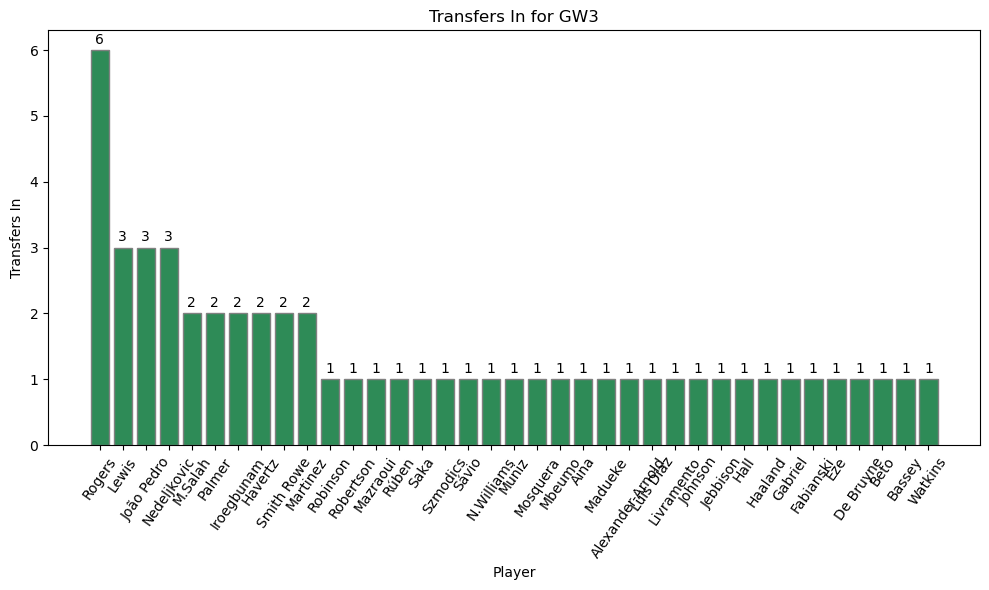

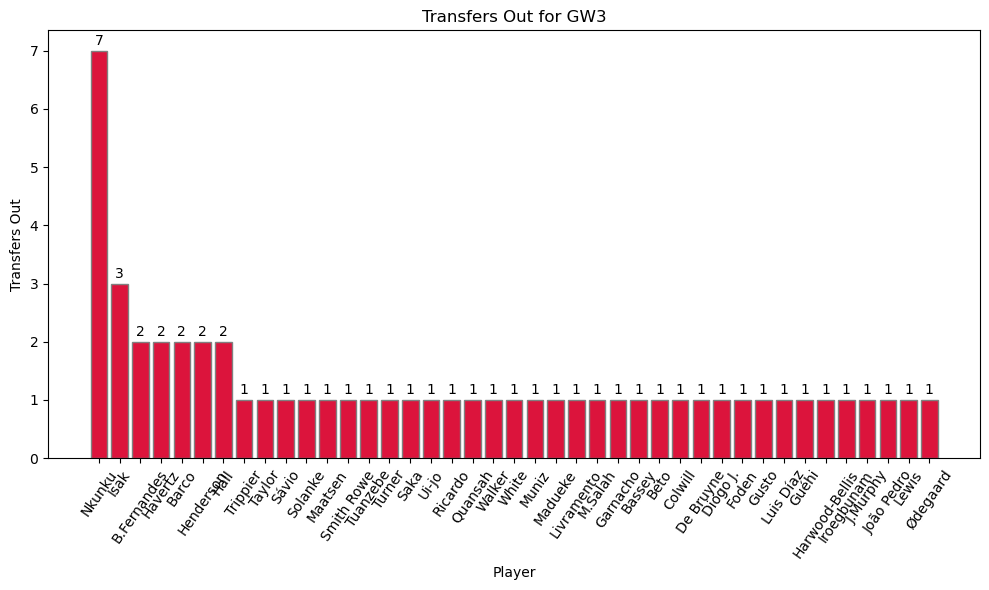

In [312]:
plot_transfers_in_out(df_in, df_out)

# OLD

In [ ]:
def plot_captaincy(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}'):
    # to store captains
    captains = []

    # fetch the team data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            picks = data['picks']

            for pick in picks:
                if pick['is_captain']==True:
                    player_id = pick['element']
                    player_name = player_to_id_mapping[player_id]
                    captains.append(player_name)

    # make it an ordered list
    captain_counts = Counter(captains)
    sorted_captains = sorted(captain_counts.items(), key=lambda x: x[1], reverse=True)
    captains, counts = zip(*sorted_captains)
    
    # plot captains count
    plt.figure(figsize=(6, 4))
    plt.bar(captains, counts)
    plt.xlabel(f'Captains')
    plt.ylabel('Count')
    plt.title(f'Captains for GW{GW}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/captaincy_GW{GW}.png')
    plt.show()

In [ ]:
def plot_most_owned(user_ids, GW, N_most_owned=10, save_dir=f'league_{league_id}/output/GW{GW}'):

    """
    Plots the most owned players for a given gameweek (GW) among a list of user IDs and saves the plot as an image.

    Parameters:
    user_ids (list): List of user IDs.
    GW (int): Gameweek number.
    N_most_owned (int, optional): Number of top owned players to display. Default is 10.
    save_dir (str, optional): Directory path where the plot image will be saved. Default is 'league_{league_id}/most_owned_GW{GW}.png'.

    Returns:
    None
    """
        
    # to store all owned players
    players = []

    # fetch the team data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            picks = data['picks']

            for pick in picks:
                player_id = pick['element']
                player_name = player_to_id_mapping[player_id]
                players.append(player_name)

    # get the top N most owned players, and their percentages
    player_counts = Counter(players)
    top_N_players = player_counts.most_common(N_most_owned)
    player_names, counts = zip(*top_N_players)
    percent_owned = [count / len(user_ids) for count in counts]

    # Plot the data
    plt.figure(figsize=(10, 6))
    bars = plt.bar(player_names, percent_owned, color='skyblue')
    plt.xlabel('Player')
    plt.ylabel('% Owned')
    plt.title(f'Most Owned Players for GW{GW}')
    plt.xticks(rotation=45)

    # Add percentage on top of each bar
    for bar, percent in zip(bars, percent_owned):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(percent * 100)}%', ha='center', va='bottom')
    plt.tight_layout()
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/most_owned_GW{GW}.png')
    plt.show()